# Differential Power Analysis

Contrary to previous lab on leakage assessment where we had control over the key value, this session's goal is to retrieve an unknown key, used during an AES encryption. The attacker can send randomly chosen plaintexts and records power consumption. 

The first -- and quick -- part will consist in collecting traces. The second part wil introduce DPA, implement this attack and retrieve the key. The last part will give further insight into this type of attacks.

## Acquisitions
1. Communicate with the chip
2. Get a trace on the scope / Power analysis on AES
3. Get a set of (traces/plaintexts) to be attacked later

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt 
import serial
import time

from tqdm.notebook import trange

In [5]:
# Install a Crypto package in the current python kernel
import sys
!{sys.executable} -m pip install Crypto
from Crypto.Cipher import AES

In [6]:
# connection to the chip / set up chip specific parameters
SCOPETYPE='OPENADC'
PLATFORM='CWLITEARM'
CRYPTO_TARGET='TINYAES128C'
CW_PATH = '/mnt/ramdisk/chipwhisperer/'

setup_script = CW_PATH  + "jupyter/Setup_Scripts/Setup_Generic.ipynb"
%run $setup_script

INFO: Found ChipWhisperer😍
scope.gain.mode                          changed from low                       to high                     
scope.gain.gain                          changed from 0                         to 30                       
scope.gain.db                            changed from 5.5                       to 24.8359375               
scope.adc.basic_mode                     changed from low                       to rising_edge              
scope.adc.samples                        changed from 24400                     to 5000                     
scope.adc.trig_count                     changed from 21129986                  to 82770887                 
scope.clock.adc_src                      changed from clkgen_x1                 to clkgen_x4                
scope.clock.adc_freq                     changed from 96000000                  to 29538459                 
scope.clock.adc_rate                     changed from 96000000.0                to 29538459.0        

Next: Program the target with th AES software, identical to the leakage assessment lab (TP2).

In [7]:
# program target with software AES
cw.program_target(scope, prog, "./simpleserial-aes-{}.hex".format(PLATFORM))

Detected known STMF32: STM32F302xB(C)/303xB(C)
Extended erase (0x44), this can take ten seconds or more
Attempting to program 6131 bytes at 0x8000000
STM32F Programming flash...
STM32F Reading flash...
Verified flash OK, 6131 bytes


### Chip communication
#### Firmware commands
The firmware consists in a simple AES-128 ciphering. There are 3 commands in the firmware:
1. `k` command + 16 bytes => set the key to this specific value 16 bytes. 
2. `p` command + 16 bytes => cipher the 16-byte message/plaintext with the key defined above.
3. `g` command + 16 bytes => cipher the 16-byte message/plaintext with an **uknown key**. This is the key you should retrieve. 

The following functions are defined and self-explicit. 



In [8]:
from time import sleep
import numpy as np
def send_key(key):
    assert type(key) is np.ndarray, "Key must be array Numpy"
    #assert all([type(octet) is np.uint8 for octet in key]), "Key must be a vector of bytes"
    assert np.shape(key) == (16,), "key length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in key]), "The value of each key byte must be between 0 and 255"
    
    target.simpleserial_write('k', bytearray(key))
    sleep(0.01)

def cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('p', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre

def secret_cipher(plain):
    assert type(plain) is np.ndarray, "Plaintext must be array Numpy"
    assert all([type(octet) is np.uint8 for octet in plain]), "Plaintext must be a vector of bytes"
    assert np.shape(plain) == (16,), "Plaintext length must be 16 bytes"
    assert all([0 <= octet <= 255 for octet in plain]), "The value of each input byte must be between 0 and 255"
    
    target.simpleserial_write('g', bytearray(plain))
    sleep(0.01)
    chiffre = target.simpleserial_read_witherrors('r', 16)
    return chiffre

### Questions:
1. Check with a random key and plaintext that the ciphering function is correct.

In [9]:
key = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)
plaintext = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)

# Key and plaintext must be wrapped into a bytearray, as the module communicate with a C-based API
cipher_python = AES.new(bytearray(key),  AES.MODE_ECB).encrypt(bytearray(plaintext))

# TODO: print the plaintext, the ciphered text, and the deciphered text
send_key(key)
ciphertext = cipher(plaintext)["full_response"].strip()


decipher_python = AES.new(bytearray(key), AES.MODE_ECB)
decrypted = decipher_python.decrypt(cipher_python)
plaintext_bytearray = bytearray(plaintext)

assert plaintext_bytearray == decrypted

print("Plaintext :")
print(plaintext_bytearray)

print("Ciphertext :")
print(ciphertext)

print("Deciphered text :")
print(decrypted)

Plaintext :
bytearray(b'\xe9\xe2\xc6\\^n(z\xd7\xbbK\x80\xdd\x9b\x82\x9a')
Ciphertext :
rBB2B804A9E300EE802C92130275A76E0
Deciphered text :
b'\xe9\xe2\xc6\\^n(z\xd7\xbbK\x80\xdd\x9b\x82\x9a'


2. Show that the key is different - and unknown - when the `secret_cipher` function is used (`g` command).

In [10]:
# TODO: use `secret_cipher` to assert that we do not know the key used on the chip !
secret_ciphertext = secret_cipher(plaintext)["full_response"].strip()

assert secret_ciphertext != ciphertext
print("We have different ciphertext for the same plaintext. We can conclude that we use a different key for secret")

We have different ciphertext for the same plaintext. We can conclude that we use a different key for secret


### Scope 
#### Goal:

We already identify the 10 AES-128 rounds in the previous lab. In this DPA attack, we will target only the first round. The goal of this section is to record 2500 traces with its corresponding plaintext. 


In [11]:
# print scope parameters
scope

cwlite Device
sn         = 442031204b3530433230352038323036
fw_version = 
    major = 0
    minor = 65
    debug = 0
gain = 
    mode = high
    gain = 30
    db   = 24.8359375
adc = 
    state          = False
    basic_mode     = rising_edge
    timeout        = 2
    offset         = 0
    presamples     = 0
    samples        = 5000
    decimate       = 1
    trig_count     = 82826191
    fifo_fill_mode = normal
clock = 
    adc_src       = clkgen_x4
    adc_phase     = 0
    adc_freq      = 29538459
    adc_rate      = 29538459.0
    adc_locked    = True
    freq_ctr      = 0
    freq_ctr_src  = extclk
    clkgen_src    = system
    extclk_freq   = 10000000
    clkgen_mul    = 2
    clkgen_div    = 26
    clkgen_freq   = 7384615.384615385
    clkgen_locked = True
trigger = 
    triggers = tio4
    module   = basic
io = 
    tio1         = serial_rx
    tio2         = serial_tx
    tio3         = high_z
    tio4         = high_z
    pdid         = high_z
    pdic         = high_z
 

In [12]:
print("Number of samples to be recorded: " + str(scope.adc.samples))

Number of samples to be recorded: 5000


1. Plot all the AES rounds

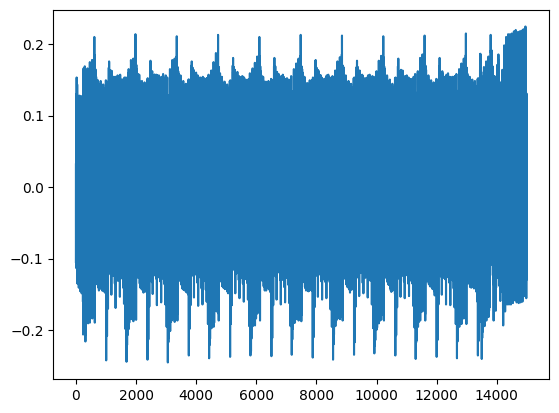

In [13]:
# TODO: define exploitable values for `sample` and `decimate` parameters
scope.adc.samples = 15000
scope.adc.decimate = 2
# arm the scope to be ready for acquistions
scope.arm()
# the command 'p' includes a signal at the beginning of AES encryption that is sent to the scope to begin acquisition
secret_cipher(plaintext)
ret = scope.capture()
wave = scope.get_last_trace()
plt.plot(wave)
plt.show()

2. Plot only the first round 

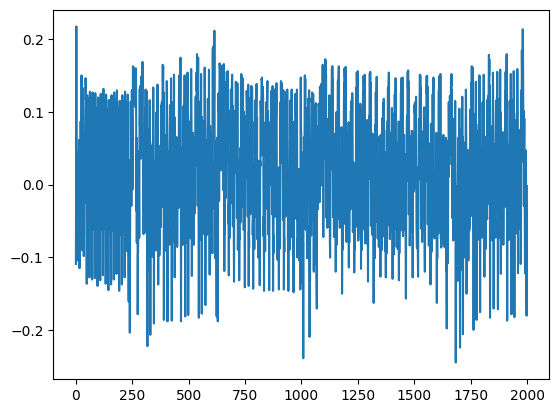

In [14]:
# TODO: 
scope.adc.samples = 2000
scope.adc.decimate = 2
# arm the scope to be ready for acquistions
scope.arm()
# the command 'p' includes a signal at the beginning of AES encryption that is sent to the scope to begin acquisition
secret_cipher(plaintext)
ret = scope.capture()
wave = scope.get_last_trace()
plt.plot(wave)
plt.show()

#### Acquistion of traces/plaintexts
 -  acquire 2000 sets of (trace/plaintext). The function `acquire_traces` is already written.

In [15]:
def acquire_traces(count=10):
    '''probe : array [scope, channel]
    count: number of curves to save
    returns plaintexts, trace
    '''    
    plaintexts = []
    traces = np.zeros((count, scope.adc.samples), dtype=float)

    for i in trange(count, desc = "Capturing"):
        plaintext = np.random.randint(low=0, high=256, size=16, dtype=np.uint8)
        plaintexts.append(plaintext)
        scope.arm()

        secret_cipher(plaintext)
        ret = scope.capture()
        if ret:
            print("Target timed out!")
            continue
        else:
            trace = scope.get_last_trace()
            traces[i] = trace
            
        #scope.stop()
    return traces, plaintexts

tr,pl = acquire_traces(2000)

Capturing:   0%|          | 0/2000 [00:00<?, ?it/s]

In [16]:
import os
dir_name = "acqui/"
try:
    os.mkdir(dir_name)
    np.save(dir_name + './tracesAES', tr)
    np.save(dir_name + '/plaintexts', pl)
    print("New files correctly saved")
except:
    # in order to avoid erasing traces
    print("Directory already created, delete it before saving new files.")

Directory already created, delete it before saving new files.


In [17]:
# AES SBOX as an array
SBOX = np.array([
    0x63, 0x7c, 0x77, 0x7b, 0xf2, 0x6b, 0x6f, 0xc5,
    0x30, 0x01, 0x67, 0x2b, 0xfe, 0xd7, 0xab, 0x76,
    0xca, 0x82, 0xc9, 0x7d, 0xfa, 0x59, 0x47, 0xf0,
    0xad, 0xd4, 0xa2, 0xaf, 0x9c, 0xa4, 0x72, 0xc0,
    0xb7, 0xfd, 0x93, 0x26, 0x36, 0x3f, 0xf7, 0xcc,
    0x34, 0xa5, 0xe5, 0xf1, 0x71, 0xd8, 0x31, 0x15,
    0x04, 0xc7, 0x23, 0xc3, 0x18, 0x96, 0x05, 0x9a,
    0x07, 0x12, 0x80, 0xe2, 0xeb, 0x27, 0xb2, 0x75,
    0x09, 0x83, 0x2c, 0x1a, 0x1b, 0x6e, 0x5a, 0xa0,
    0x52, 0x3b, 0xd6, 0xb3, 0x29, 0xe3, 0x2f, 0x84,
    0x53, 0xd1, 0x00, 0xed, 0x20, 0xfc, 0xb1, 0x5b,
    0x6a, 0xcb, 0xbe, 0x39, 0x4a, 0x4c, 0x58, 0xcf,
    0xd0, 0xef, 0xaa, 0xfb, 0x43, 0x4d, 0x33, 0x85,
    0x45, 0xf9, 0x02, 0x7f, 0x50, 0x3c, 0x9f, 0xa8,
    0x51, 0xa3, 0x40, 0x8f, 0x92, 0x9d, 0x38, 0xf5,
    0xbc, 0xb6, 0xda, 0x21, 0x10, 0xff, 0xf3, 0xd2,
    0xcd, 0x0c, 0x13, 0xec, 0x5f, 0x97, 0x44, 0x17,
    0xc4, 0xa7, 0x7e, 0x3d, 0x64, 0x5d, 0x19, 0x73,
    0x60, 0x81, 0x4f, 0xdc, 0x22, 0x2a, 0x90, 0x88,
    0x46, 0xee, 0xb8, 0x14, 0xde, 0x5e, 0x0b, 0xdb,
    0xe0, 0x32, 0x3a, 0x0a, 0x49, 0x06, 0x24, 0x5c,
    0xc2, 0xd3, 0xac, 0x62, 0x91, 0x95, 0xe4, 0x79,
    0xe7, 0xc8, 0x37, 0x6d, 0x8d, 0xd5, 0x4e, 0xa9,
    0x6c, 0x56, 0xf4, 0xea, 0x65, 0x7a, 0xae, 0x08,
    0xba, 0x78, 0x25, 0x2e, 0x1c, 0xa6, 0xb4, 0xc6,
    0xe8, 0xdd, 0x74, 0x1f, 0x4b, 0xbd, 0x8b, 0x8a,
    0x70, 0x3e, 0xb5, 0x66, 0x48, 0x03, 0xf6, 0x0e,
    0x61, 0x35, 0x57, 0xb9, 0x86, 0xc1, 0x1d, 0x9e,
    0xe1, 0xf8, 0x98, 0x11, 0x69, 0xd9, 0x8e, 0x94,
    0x9b, 0x1e, 0x87, 0xe9, 0xce, 0x55, 0x28, 0xdf,
    0x8c, 0xa1, 0x89, 0x0d, 0xbf, 0xe6, 0x42, 0x68,
    0x41, 0x99, 0x2d, 0x0f, 0xb0, 0x54, 0xbb, 0x16], dtype=int)

In case you lose or modify the variables traces / plaintexts, you can retrieve them by executing the following cell. It recovers all data by reading the saved files. 

In [18]:
# load traces
traces_exp = np.load("./acqui/tracesAES.npy")
plaintexts_exp = np.load("./acqui/plaintexts.npy")

traces_simu = np.load("./simu/traces_simu.npy")
plaintexts_simu  = np.load("./simu/plaintexts.npy")

You can check if the traces are correct when plotting few curves.

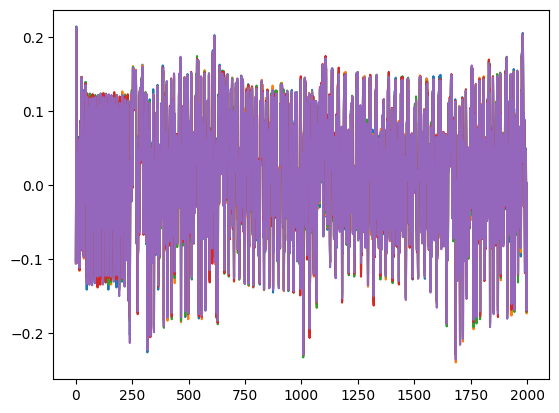

In [19]:
plt.figure()
plt.plot(traces_exp[:5].T)
plt.show()

You can also have a look at the first plaintexts.

In [20]:
print (plaintexts_simu[:5])

[[252 216  49  40 223 127 209  53 118 251  73 247  29 175  38 102]
 [ 78 177  11   7 157  75  32   1 138 103  10 230  81  13  55  70]
 [ 29 152   2 228  96 179 196  80 236 132 236  99  75 162   3 146]
 [235  94  68 113 227  75  15  94 170 233 165 221 177 157 233 255]
 [134  77 234 121  60 150 154 216 214 192  37  80  97 236  32  92]]


### Choose the dataset: simulation or experimental

In order to quickly debug, we advise to first use the simulation sets (`traces_simu` and `plaintexts_simu`). The number of curves ands samples are smaller in this set. When all the DPA attack is validated for this set, you can switch to the real-experimental traces to retrieve the key by modifying the following cell. 

In [21]:
traces = traces_simu
messages = plaintexts_simu
#traces = traces_exp
#messages = plaintexts_exp

### Target + Leakage model : Selection function
The selection function (aka *target function*) is a function which depends on a secret (a key for instance) and a known value (message/plaintext/ciphertext):

- first, you need to write a `target_function` - for example, you can consider the output `byte_i` after the SBOX has been applied, during the first AES round
- second, you need to write a (simple) leakage model for the DSA: from a byte computed with the `target_function`, chose a particular bit that will be used to partition the set of traces
- then, write a typical `selection` function for DPA, which shall return {0,1} and depends on the $j^{th}$ bit (`bit_j`) output of an AES state (`byte_i`) after the first SBOX
- to run the attack, you now just have to choose a position --- *i.e.* a tuple (`byte_i`, `bit_j`), and run your `selection` function over all the possible keys.

## DPA attacks

The attack will target the values after the first SBox, which depends on the plaintext and the key. These values shall be separated into 2 parts, hence the Differential name of this attack, by a predefined `selection` function. In our case, we will select 1 bit of this value. This is the bit where the physical leakage is expected.

There are 16 different byte position in an AES state so we will need 16 independant DPA attack to recover the whole key. 
![Using the outbput of the first SBOX as a selection function](images/selection_target.PNG)

### Questions
1. Determine the `target` function which calculate the intermediate value for a given plaintext, key and byte position

In [22]:
# returns the output values after the first SBOX 
def target_function(msg, key, byte_i):
    ''' msg: 16 byte AES plaintext
        key: 1 byte of the AES key (your key guess)
        byte_i:  target byte position
        returns: 1 byte at the output of first SBOX
    '''
    intermediate_xor = msg[byte_i] ^ key
    sbox_output = SBOX[intermediate_xor]
    return sbox_output


2. Determine the `selection` function, which returns (0,1) the value of `bit_j` of the target function with `byte_i`. You can use an intermediate leakage function which is already written.    
3. The selection function we will use in the attack is `sel_0` which target the first bit.  

In [23]:
# returns the value of bit_j of a byte
def leakage_function(byte_i, bit_j):
    ''' byte: 
        bit: 
        returns: 0/1 
    '''
    return (byte_i >> bit_j) & 1

def selection(msg, key, byte_i, bit_j):
    ''' mess: message/plaintext
     key : key
     byte_n : the targeted byte
     bit_n : the targeted bit in the byte
     returns 0/1 
    '''
    intermediate_byte = target_function(msg, key, byte_i)
    return leakage_function(intermediate_byte, bit_j)
    
# sel0 is selection  with bit_j = 0 
# this function will be used fo further attacks
def sel0(msg, key, byte_i):
    return selection(msg, key, byte_i, 0)


### Attack


Knowing the plaintext, if you guess a byte of the key, you can determine the value of the selection function and choose in which set the trace is.  If this is the correct key, there will a statistical difference between the 2 sets, that you can calculate. 
![Computing differential t](images/selection_function.PNG)


You can calculate this `hypothesis` trace (in red on the Figure) for every key guess. The higher value of this `hypothesis` will correspond the more likely key.  

The whole algorithm to recover a byte of the key - already seen during the lectures - can be summarized below:

```
    For each key_guess :                                                        # among 256 possibilities
        For each (trace, plaintext)
            Compute selection_function(key_guess, plaintext)
            Store the trace in the correct set according to selection_output 
        Compute the differential trace of the 2 sets 
```
Take care that the 2 sets will not have same cardinal (number of elements) so be sure to normalize the 2 sets by the number of elements. 

We can now find the guess which has the highest peak : it is the **most likely key**.

### Questions:
1. For a key `guess`, construct the `hypothesis` vector for every couple (`traces`, `messages`).

In [24]:
def hypothesis(guess, messages, traces, selection_function):
    '''guess: key for this hypothesis
    messages: vector of n values 
    traces: matrix of traces (n . t)
    selection_function: a funtion which takes (m, k) as inputs and returns (0,1). You can use a lambda function derived from 
        the sel0 function
    returns hypothesis(vector)
    '''
    
    # TODO: build the hypothesis
    selection_bits = np.array([selection_function(m,guess) for m in messages], dtype=bool)

    traces_1 = traces[selection_bits]
    traces_0 = traces[~selection_bits]

    if len(traces_0) == 0 or len(traces_1) == 0:
        return np.zeros(traces.shape[1])

    mean_1 = np.mean(traces_1, axis=0)
    mean_0 = np.mean(traces_0, axis=0)

    
    # compute and return result
    return mean_1 - mean_0

2. Plot this hypothesis vector for simulated traces and key guess 0, on byte 0 and compare with key guess 0xC1. Comment the result.

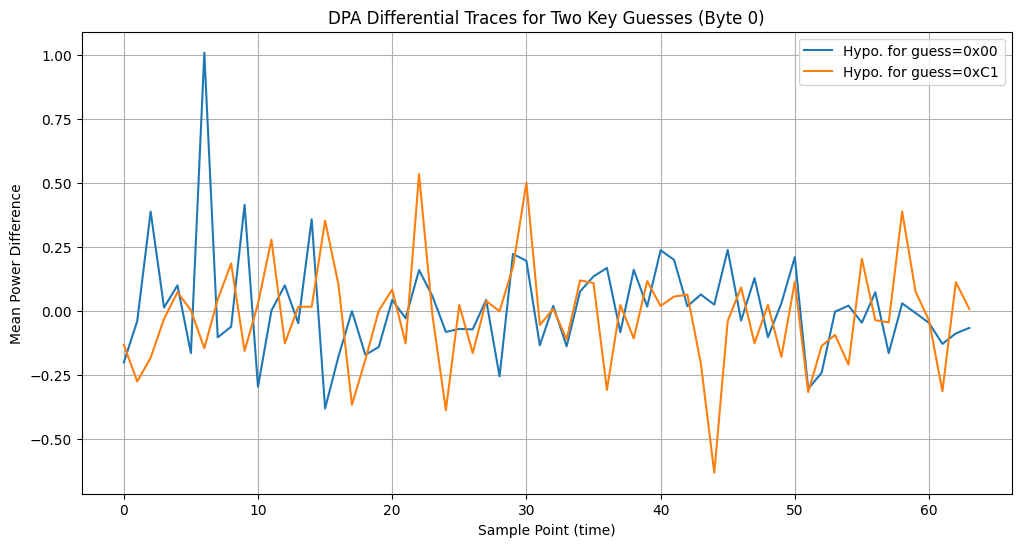

In [25]:
# TODO
target_byte = 0

selection_function_b0 = lambda m, k: sel0(m, k, target_byte)

guess_0 = 0x00
hypo_trace_0 = hypothesis(guess_0, messages, traces, selection_function_b0)

guess_c1 = 0xC1
hypo_trace_c1 = hypothesis(guess_c1, messages, traces, selection_function_b0)

plt.figure(figsize=(12, 6))
plt.plot(hypo_trace_0, label="Hypo. for guess=0x00")
plt.plot(hypo_trace_c1, label="Hypo. for guess=0xC1")

plt.title("DPA Differential Traces for Two Key Guesses (Byte 0)")
plt.xlabel("Sample Point (time)")
plt.ylabel("Mean Power Difference")
plt.legend()
plt.grid(True)
plt.show()

3. Construct the resulting matrix h for every key guesses and plot it. 

In [26]:
def dpa(messages, traces, selection_function):
    # TODO: implement DPA
    num_samples = traces.shape[1]
    num_guesses = 256

    h = np.zeros((num_guesses, num_samples))

    for guess in trange(num_guesses, desc="Attacking key byte.."):
        h[guess] = hypothesis(guess, messages, traces, selection_function)

    return h

target_byte = 0
h = dpa(messages, traces, selection_function_b0)

Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

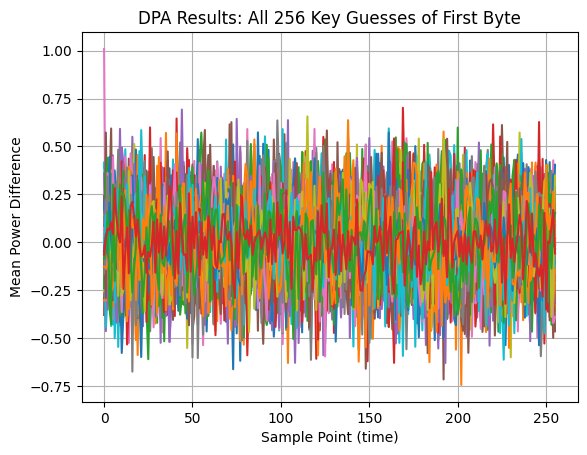

In [27]:
plt.figure()
# TODO: plot the DPA results
plt.plot(h)
plt.title("DPA Results: All 256 Key Guesses of First Byte")
plt.xlabel("Sample Point (time)")
plt.ylabel("Mean Power Difference")
plt.grid(True)
plt.show()

4. Determine a criteria to find the correct key byte 0 and find this first key byte. 

In [28]:
# TODO 
correct_key = 0
peak_values_per_guess = np.max(np.abs(h), axis=1)

correct_key = np.argmax(peak_values_per_guess)

print(f"The key byte with the highest peak is : 0x{correct_key:02x}")

The key byte with the highest peak is : 0x00


5. Retrieve every key byte and find the final key.

In [29]:
key = [0] * 16
to_plot = []
time_pos = []
nb_traces = 1000

for pos in range(16):
    # TODO: find key byte, and corresponding time position
    selection_function_bn = lambda m, k, pos=pos: sel0(m, k, pos)

    h = dpa(messages, traces, selection_function_bn)
    
    correct_key = 0
    peak_values_per_guess = np.max(np.abs(h), axis=1)
    correct_key = np.argmax(peak_values_per_guess)
    time_of_peak = np.argmax(np.abs(h[correct_key]))
    time_pos.append(time_of_peak)
    
    key[pos] = correct_key
    print("key_" + str(pos) + " = " + hex(key[pos]))

Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_0 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_1 = 0x1


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_2 = 0x2


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_3 = 0x3


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_4 = 0x4


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_5 = 0xca


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_6 = 0xfe


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_7 = 0x7


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_8 = 0xde


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_9 = 0xc0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_10 = 0xd


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_11 = 0xed


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_12 = 0xc


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_13 = 0xd


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_14 = 0xe


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_15 = 0xf


## Further investigations

1. Find the time position of the leakage for every key byte. 

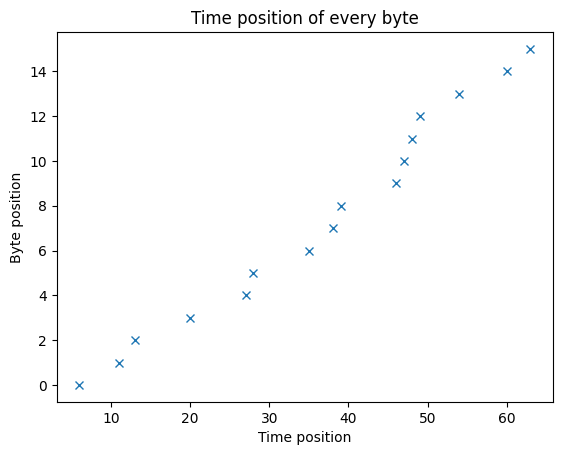

In [30]:
plt.plot(time_pos, list(range(16)), 'x')
plt.xlabel("Time position")
plt.ylabel("Byte position")
plt.title("Time position of every byte")
plt.show()

### Determine how many curves are needed to retrieve a key byte, or the whole key.

1. Rank the key, knowing the correct one, after `nb_traces`.

The rank of a key is defined as the position of the correct key in the list of all possible keys, sorted by the likeliness.
For a sufficient number of curves, if the attacked implementation does leak some information (*i.e.* if our attack is supposed to work), the rank of the key will eventually become 1.

In [31]:
def rank_array(correct_key, nb_traces, byte_number):
    """
    correct key: the attacked byte of the actual correct key, that we retrieved in previous attack
    nb_traces: the number of trace to use in this attack
    byte_number: the position of the attacked byte in the key
    """
    rank = 0
    # TODO: compute the correct rank for the given number of traces
    traces_subset = traces[:nb_traces]
    messages_subset = messages[:nb_traces]

    selection_func_n = lambda m, k, b=byte_number: sel0(m, k, b)
    num_samples = traces_subset.shape[1]
    num_guesses = 256
    h = np.zeros((num_guesses, num_samples))

    for guess in range(num_guesses):
        h[guess] = hypothesis(guess, messages_subset, traces_subset, selection_func_n)

    peak_values_per_guess = np.max(np.abs(h), axis=1)

    sorted_guess_indices = np.argsort(peak_values_per_guess)[::-1]

    rank_index = np.where(sorted_guess_indices == correct_key)[0][0]

    rank = rank_index+1

    return rank

2. Calculate the minimum number of traces to find the first byte of the key

In [32]:
min_traces = 0
mi, ma, step = 10, 1000, 10
byte_number = 0
# TODO: find the minimal number of trace for the correct key to have rank 1
correct_key_for_byte = key[byte_number]
already_min = 0

trace_counts = list(range(mi, ma, step))
ranks = []

for i in trange(mi, ma, step, desc = "Computing minimal number of traces"):
    rank = rank_array(correct_key_for_byte, i, byte_number)
    ranks.append(rank)
    if rank == 1 and already_min == 0:
        min_traces = i
        already_min = 1
print(min_traces)

Computing minimal number of traces:   0%|          | 0/99 [00:00<?, ?it/s]

610


3. Plot the correct key rank with an increasing number of traces.

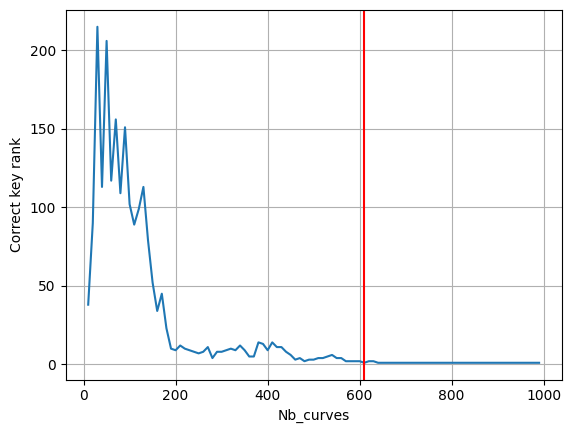

In [33]:
plt.figure()
# TODO : plot ranking in function of the number of traces
plt.plot(trace_counts, ranks)
plt.axvline(x=min_traces, color='r')
plt.xlabel("Nb_curves")
plt.ylabel("Correct key rank")
plt.grid()
plt.show()

4. Attack another part of the algorithm, for instance the first AddRoundKey

In [34]:
## TODO
def target_function_ark(msg, key, byte_i):
    intermediate_xor = msg[byte_i] ^ key
    return intermediate_xor

# returns the value of bit_j of a byte
def leakage_function_ark(byte_i, bit_j):
    return (byte_i >> bit_j) & 1

def selection_ark(msg, key, byte_i, bit_j):
    intermediate_byte = target_function_ark(msg, key, byte_i)
    return leakage_function_ark(intermediate_byte, bit_j)
    

def sel0_ark(msg, key, byte_i):
    return selection_ark(msg, key, byte_i, 0)

key = [0] * 16
to_plot = []
time_pos = []
nb_traces = 1000

for pos in range(16):
    # TODO: find key byte, and corresponding time position
    selection_function_ark = lambda m, k, pos=pos: sel0_ark(m, k, pos)

    h = dpa(messages, traces, selection_function_ark)
    
    correct_key = 0
    peak_values_per_guess = np.max(np.abs(h), axis=1)
    correct_key = np.argmax(peak_values_per_guess)
    time_of_peak = np.argmax(np.abs(h[correct_key]))
    time_pos.append(time_of_peak)
    
    key[pos] = correct_key
    print("key_" + str(pos) + " = " + hex(key[pos]))

## The attack doesn't work, because the outputs after AddRoundKey is hard to distinguish, making it hard to apply DPA Attack. That is why SBOX is the classic target.

Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_0 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_1 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_2 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_3 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_4 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_5 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_6 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_7 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_8 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_9 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_10 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_11 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_12 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_13 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_14 = 0x0


Attacking key byte..:   0%|          | 0/256 [00:00<?, ?it/s]

key_15 = 0x0
